In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_pdb_data_no_seq = pd.read_csv('resources/pdb_data_no_dups.csv')
df_pdb_seq = pd.read_csv('resources/pdb_data_seq.csv')
print("..Read data files..")

..Read data files..


In [3]:
# filtering out only protein structures
df_protein_seq = df_pdb_seq[(df_pdb_seq['macromoleculeType'] == 'Protein')]

In [4]:
# joining two data sets for protein Seq - classification

df_protein_final = df_protein_seq.merge(df_pdb_data_no_seq)

df_protein_seq_final = df_protein_final[['sequence', 'classification']]

df_protein_seq_final.head()

,sequence,classification
0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT
1,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,HYDROLASE(O-GLYCOSYL)
2,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT
3,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,HYDROLASE(O-GLYCOSYL)
4,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT


In [5]:
df_protein_seq_final = df_protein_seq_final.dropna()
print("filtered data with NA values")

filtered data with NA values


In [6]:
from utilities.EmbeddingEncoder import EmbeddingEncoder

embed_enoder = EmbeddingEncoder()

embed_enoder.find_unique_amino_acids(df_protein_seq_final['sequence'])
print("Unique Amino Acid Set...")

Unique Amino Acid Set...


In [7]:
embed_enoder.create_embed_encoder()
print(embed_enoder.embed_encoder)

{'I': 0, 'T': 1, 'R': 2, 'K': 3, 'S': 4, 'B': 5, 'M': 6, 'L': 7, 'Y': 8, 'X': 9, 'W': 10, 'H': 11, 'V': 12, 'Q': 13, 'A': 14, 'O': 15, 'U': 16, 'F': 17, 'Z': 18, 'N': 19, 'C': 20, 'E': 21, 'P': 22, 'G': 23, 'D': 24}


In [8]:
from utilities.DataPreProcessor import DataPreProcessor

count_dict = df_protein_seq_final['classification'].value_counts().to_dict()
data_pre_processor = DataPreProcessor(count_dict,embed_enoder,None)

In [9]:
## delete least preferred sequences
data_pre_processor.del_least_preferred()

df_protein_seq_final_for_modeling = \
    df_protein_seq_final[df_protein_seq_final['classification']
        .isin(data_pre_processor.count_dict_keys_as_list())]

df_protein_seq_final_for_modeling = \
    df_protein_seq_final_for_modeling.reset_index(drop=True)
print("final Shape of the DataSet {}".format(df_protein_seq_final_for_modeling.shape))

final Shape of the DataSet (291355, 2)


In [10]:
## only considering sequences of length between 50 and 1200
df_protein_seq_final_for_modeling = \
    df_protein_seq_final_for_modeling[df_protein_seq_final_for_modeling.apply(
        lambda x: len(x['sequence']) <=1200 and len(x['sequence']) >=50 ,axis=1
    )]

In [11]:
print("final Shape of the DataSet {}".format(df_protein_seq_final_for_modeling.shape))

final Shape of the DataSet (271914, 2)


In [12]:
X_sequences = df_protein_seq_final_for_modeling['sequence']
y_label = df_protein_seq_final_for_modeling['classification']

In [13]:
## test process sequences

data_pre_processor.process_seqs_to_embeddings(X_sequences[:1000],y_label[:1000],1200)
print("Getting Processed Seqs")
print(data_pre_processor.get_x().shape)
print("getting labels")
print(data_pre_processor.get_y().shape)
# print("getting protein categories")
# print(data_pre_processor.get_protein_categoeies())

Getting Processed Seqs
(1000, 1200)
getting labels
(1000, 35)


## LSTM Modeling

In [16]:
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras import regularizers

In [17]:
embed_vol = 5000
embed_dim = 300
num_features = 25
max_seq_length = 1200
## AAs are supposed to be integer encoded for embedding layer 

model = Sequential()
model.add(Embedding(embed_vol,embed_dim,input_length=data_pre_processor.get_x().shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(len(data_pre_processor.get_protein_categoeies()),activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1200, 300)         1500000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1198, 32)          28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 599, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 19168)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 35)                670915    
Total params: 2,199,747
Trainable params: 2,199,747
Non-trainable params: 0
_________________________________________________________________
None


## Modeling the first 1000 Sequences

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_pre_processor.get_x(), data_pre_processor.get_y(), test_size=0.20, random_state=42)

In [19]:
print("train data shape is {} and {}".format(X_train.shape,y_train.shape))
print("test data shape is {} and {}".format(X_test.shape,y_test.shape))

train data shape is (800, 1200) and (800, 35)
test data shape is (200, 1200) and (200, 35)


In [ ]:
# from keras.callbacks import TensorBoard

# tensor_board = TensorBoard(log_dir='logs/Graph', histogram_freq=0, write_graph=True, write_images=True)

Train on 640 samples, validate on 160 samples
Epoch 1/5
640/640 [==============================] - 14s 22ms/step - loss: 2.6208 - acc: 0.2906 - val_loss: 2.1164 - val_acc: 0.3812
Epoch 2/5
640/640 [==============================] - 14s 21ms/step - loss: 1.7914 - acc: 0.5047 - val_loss: 1.5486 - val_acc: 0.6438
Epoch 3/5
640/640 [==============================] - 14s 21ms/step - loss: 1.0439 - acc: 0.7156 - val_loss: 1.0686 - val_acc: 0.7000
Epoch 4/5
640/640 [==============================] - 14s 21ms/step - loss: 0.4725 - acc: 0.8703 - val_loss: 0.8125 - val_acc: 0.8000
Epoch 5/5
640/640 [==============================] - 14s 21ms/step - loss: 0.2340 - acc: 0.9516 - val_loss: 0.7805 - val_acc: 0.8000


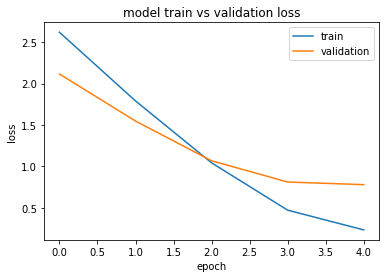

In [20]:
history = model.fit(X_train,y_train,epochs=5,verbose=1,batch_size=32,validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [21]:
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = 16)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

Score: 1.06
Validation Accuracy: 0.81
